In [1]:
# you can check out several features that librosa offers here:
# 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
# load file
# file_name = 'audio_files/sofianos/otanSynantoKapoion.wav'
file_name = '../audio_files/sofianos/eipa.wav'
y, sr = librosa.load(file_name, sr=44100)
sd.play( y , sr )

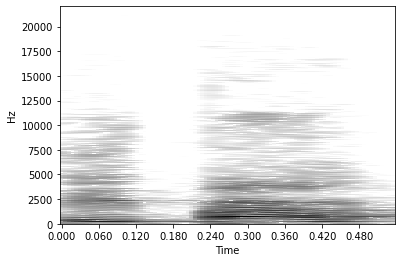

In [3]:
n_fft = 4096
hop_size = 256
p = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
d = librosa.amplitude_to_db( np.abs(p), ref=np.max )
librosa.display.specshow(d, cmap='gray_r', sr=sr, hop_length=hop_size, x_axis='time', y_axis='linear')

(30.0, 6000.0)

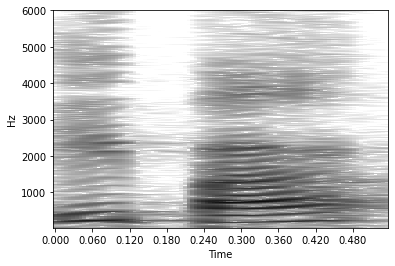

In [3]:
# in short speech segmetns we get clearer results with:
# larger windows (greater resolution on low frequencies)
# smaller hop sizes (greater time accuracy)
n_fft = 4096
hop_size = 256
p = librosa.stft(y, n_fft=n_fft, hop_length=hop_size)
d = librosa.amplitude_to_db( np.abs(p), ref=np.max )
librosa.display.specshow(d, cmap='gray_r', sr=sr, hop_length=hop_size, x_axis='time', y_axis='linear')
# and also, if we restrict to speech-relevant frequencies
lowest_freq = 30
highest_freq = 6000
plt.ylim([lowest_freq, highest_freq])

In [4]:
# simple explanation of correlation and autocorrelation
# completely correlated
x1 = np.array( [1,2,3,4,3,2,1] )
x2 = np.array( [6,8,10,12,10,8,6] )

c = np.corrcoef( x1 , x2 )
print("completely correlated: ", c)
# we simply need
c[0][1]

completely correlated:  [[1. 1.]
 [1. 1.]]


0.9999999999999998

In [6]:
# completely inversely correlated
x1 = np.array( [1,2,3,4,3,2,1] )
x2 = np.array( [9,8,7,6,7,8,9] )

c = np.corrcoef( x1 , x2 )
print("completely correlated: ", c)

completely correlated:  [[ 1. -1.]
 [-1.  1.]]


In [8]:
# uncorrelated
x1 = np.array( [1,2,3,4,3,2,1] )
x2 = np.array( [1,3,2,4,3,5,6] )

c = np.corrcoef( x1 , x2 )
print("completely correlated: ", c)

completely correlated:  [[ 1.         -0.07472032]
 [-0.07472032  1.        ]]


1.0


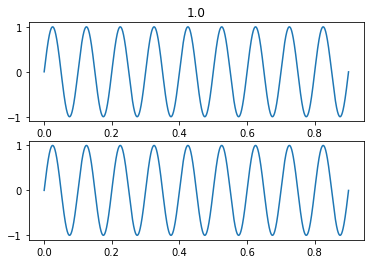

In [9]:
# autocorrelation: correlation of an array with itself with different time lags
sr = 44100

t = np.arange(sr)/sr

f = 10
s = np.sin( 2*np.pi*f*t )

lag_samples = 4410
s1 = s[lag_samples:]
s2 = s[:-lag_samples]

c = np.corrcoef(s1 , s2)
print(str(c[0][1]))

plt.subplot( 211 )
plt.plot( np.arange(s1.size)/sr , s1 )
plt.title(str(c[0][1]))
plt.subplot( 212 )
plt.plot( np.arange(s2.size)/sr , s2 )

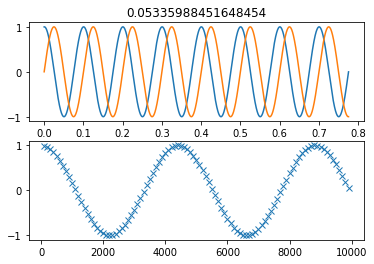

In [10]:
from IPython.display import clear_output
lag_values = np.arange(100, 10000, 100)
corrs = np.zeros( lag_values.size )

for i in range( lag_values.size ):
    plt.clf()
    clear_output(wait=True)
    lag_samples = int(lag_values[i])
    s1 = s[lag_samples:]
    s2 = s[:-lag_samples]
    
    c = np.corrcoef(s1 , s2)
    corrs[i] = c[0][1]
    
    plt.subplot( 211 )
    plt.plot( np.arange(s1.size)/sr , s1 )
    plt.plot( np.arange(s2.size)/sr , s2 )
    plt.title(str(c[0][1]))
    plt.subplot( 212 )
    plt.plot( lag_values , corrs, 'x' )
    plt.pause(0.01)

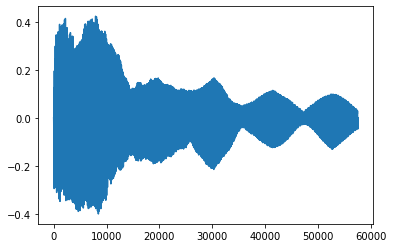

In [11]:
s, sr = librosa.load('../audio_files/guitar_note.wav')
plt.plot( np.arange(s.size) , s )

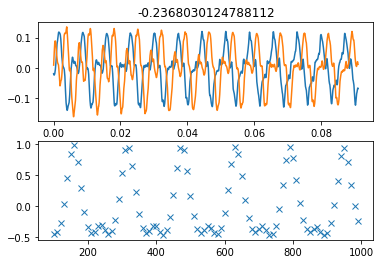

In [12]:
s, sr = librosa.load('../audio_files/guitar_note.wav')
s = s[22050:25050]

lag_values = np.arange(100, 1000, 10)
corrs = np.zeros( lag_values.size )

for i in range( lag_values.size ):
    plt.clf()
    clear_output(wait=True)
    lag_samples = int(lag_values[i])
    s1 = s[lag_samples:]
    s2 = s[:-lag_samples]
    
    c = np.corrcoef(s1 , s2)
    corrs[i] = c[0][1]
    
    plt.subplot( 211 )
    plt.plot( np.arange(s1.size)/sr , s1 )
    plt.plot( np.arange(s2.size)/sr , s2 )
    plt.title(str(c[0][1]))
    plt.subplot( 212 )
    plt.plot( lag_values , corrs, 'x' )
    plt.pause(0.01)

#### Extracting pitch with autocorrelation

General rule: the lag value that provides maximum autocorrelation, indicates the fundamental frequency.

##### Example:
Assuming a sample rate of 44100, if the maximum lag value is given with a lag of 22050, then the signal should be closer to repeating every 22050 samples, i.e. every 0.5 seconds, thus have a frequency of 2Hz.

##### In general:
Assuming a sample rate of $f_s$, it the maximum lag value is given with a lag of $k$ samples, then the signal should be closer to repeating every $k$ samples, i.e. every $\frac{k}{f_s}$ seconds, thus have a frequency of

$$ f = \frac{f_s}{k}\text{.} $$

Therefore, the necessary lag value for identifying a frequency f should be:

$$ k = \frac{f_s}{f}\text{.} $$

##### Practically:
- Larger lag values capture lower frequencies.
- As in FFT, looking at larger windows gives better results in lower frequencies.
- For voice applications, male voice can reach as low as 80Hz, i.e. a time lag of $ k = \frac{44100}{80} = 552$ is required.

Text(0.5, 1.0, 'max autocorrelation for lag: 314')

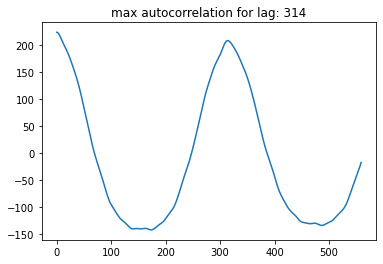

In [14]:
# librosa's autocorrelation
s, sr = librosa.load('../audio_files/guitar_note.wav', sr=44100)
# s = s[22050:25050]
s = s[10000:15000]

# this recording has a guitar C# note at around 138.5Hz
lag_max = 560
# lag_max = 5*560
a = librosa.autocorrelate( s , max_size=lag_max )
# plt.plot( np.arange(170) , a[:170] )
plt.plot( np.arange(lag_max) , a )
plt.title( 'max autocorrelation for lag: ' + str(np.argmax( a[50:] )+50) )

Text(0.5, 1.0, 'max autocorrelation for lag: 314')

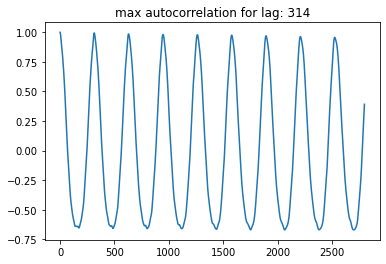

In [15]:
s, sr = librosa.load('../audio_files/guitar_note.wav', sr=44100)
# s = s[22050:25050]
s = s[10000:15000]

# this recording has a guitar C# note at around 138.5Hz
# lag_max = 560
lag_max = 5*560

lag_values = np.arange(lag_max)
corrs = np.zeros( lag_max )

for i in range( lag_max ):
    lag_samples = int(lag_values[i])
    if i != 0:
        s1 = s[lag_samples:]
        s2 = s[:-lag_samples]
    else:
        s1 = s
        s2 = s
    c = np.corrcoef(s1 , s2)
    corrs[i] = c[0][1]

plt.plot( np.arange(lag_max) , corrs )
plt.title( 'max autocorrelation for lag: ' + str(np.argmax( corrs[50:] )+50) )

/var/folders/k_/fvgjkvys5yq973r5xjs_hknc0000gp/T/ipykernel_3298/3724282467.py:4: FutureWarning: Pass fmin=30, fmax=2000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f0, voiced_flag, voiced_probs = librosa.pyin(y, lowest_freq, highest_freq, sr=sr, frame_length = n_fft, hop_length=hop_size)


(30.0, 2000.0)

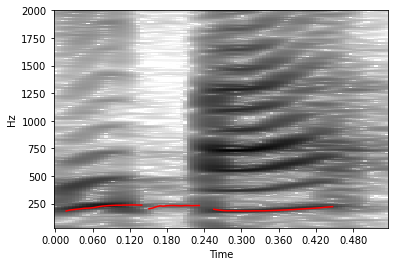

In [17]:
librosa.display.specshow(d, cmap='gray_r', sr=sr, hop_length=hop_size, x_axis='time', y_axis='linear')
t = np.arange(0, y.size, hop_size)/sr
# f0
f0, voiced_flag, voiced_probs = librosa.pyin(y, lowest_freq, highest_freq, sr=sr, frame_length = n_fft, hop_length=hop_size)
plt.plot( t , f0 , 'r')
# and also, if we restrict ourselves to speech-relevant frequencies
lowest_freq = 30
highest_freq = 2000
plt.ylim([lowest_freq, highest_freq])

/var/folders/k_/fvgjkvys5yq973r5xjs_hknc0000gp/T/ipykernel_10391/1743707822.py:13: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fbins = librosa.fft_frequencies(sr, n_fft=n_fft)


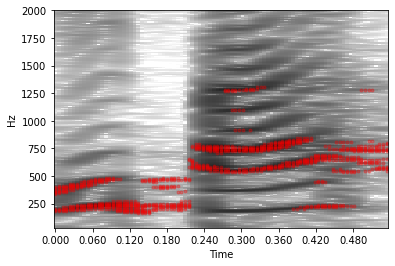

In [15]:
librosa.display.specshow(d, cmap='gray_r', sr=sr, hop_length=hop_size, x_axis='time', y_axis='linear')
# and also, if we restrict to speech-relevant frequencies
lowest_freq = 30
highest_freq = 2000
plt.ylim([lowest_freq, highest_freq])
#  towards identifying formants
fmnts = np.zeros( (10, d.shape[1]) )
for i in range(d.shape[1]):
    fmnts[:, i] = np.argsort( d[:,i] )[::-1][:10]

fmnts = fmnts.astype(int)

fbins = librosa.fft_frequencies(sr, n_fft=n_fft)
t = np.arange(0, y.size, hop_size)/sr
# todo: get array of colors to use from a color map
for i in range(fmnts.shape[0]):
    # todo: eliminate columnts that correspond to nans in f0
    plt.plot( t , fbins[ fmnts[i,:] ] , 'r.', alpha=0.3)

/var/folders/k_/fvgjkvys5yq973r5xjs_hknc0000gp/T/ipykernel_10391/4164265059.py:1: FutureWarning: Pass y=[-0.00738525 -0.00769043 -0.00933838 ...  0.00344849  0.00332642
  0.00247192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec = librosa.feature.melspectrogram(y, n_fft=n_fft, hop_length=hop_size, n_mels=128, fmax=8000)


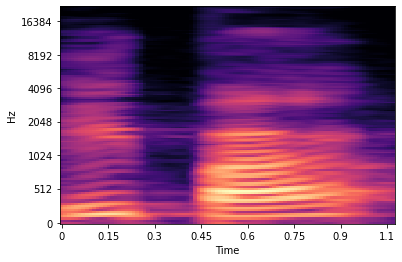

In [16]:
mel_spec = librosa.feature.melspectrogram(y, n_fft=n_fft, hop_length=hop_size, n_mels=128, fmax=8000)
mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_dB, sr=sr, x_axis='time', y_axis='mel')

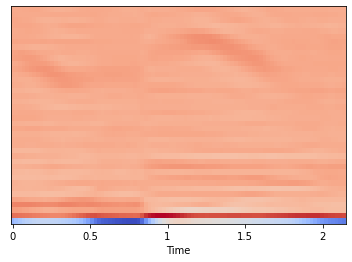

In [17]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, n_fft=n_fft, hop_length=hop_size, n_mels=128, fmax=8000)
librosa.display.specshow(mfccs, x_axis='time')